In [110]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [188]:
train_df = pd.read_csv('train.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [189]:
data_dicom = pd.read_csv('/Volumes/ALEXIS/ai_project_cranfield/dicom_metadata.csv')
data_dicom.head()

,File Name,Transfer Syntax UID,SOP Class UID,SOP Instance UID,Version,Photometric Interpretation,Pixel Representation,High Bit,Samples per Pixel,Bits Allocated,...,Lossy Image Compression,Lossy Image Compression Ratio,Patient's Sex,Patient's Age,Rows,Columns,Pixel Spacing,Bits Stored,Window Center,Window Width
0,f7f7736401b22c94a9d2b09425adeab9.dicom,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1.1,f7f7736401b22c94a9d2b09425adeab9,INF_3.9,MONOCHROME2,0,11,1,16,...,0.0,NaN,F,037Y,3028,2517,"[0.139, 0.139]",12,2048.0,4096.0
1,93ae57ca1df1d19c6d64155e74e14d23.dicom,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1.1,93ae57ca1df1d19c6d64155e74e14d23,NaN,MONOCHROME2,0,13,1,16,...,NaN,NaN,O,Y,3072,3072,"[0.139000, 0.139000]",14,10287.0,5292.0
2,f1a45afaee0efd07fef17057f3942464.dicom,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,f1a45afaee0efd07fef17057f3942464,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,...,0.0,NaN,M,NaN,2880,2304,"[0.15, 0.15]",12,2047.0,4095.0
3,559fdfb3b9db3eb206b9521824f716e3.dicom,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,559fdfb3b9db3eb206b9521824f716e3,OFFIS_DCMTK_360,MONOCHROME2,0,13,1,16,...,NaN,NaN,M,038Y,3072,2540,"[0.140, 0.140]",14,10075.0,10242.0
4,371d6f540ac601affe81e547b05c551a.dicom,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,371d6f540ac601affe81e547b05c551a,OFFIS_DCMTK_360,MONOCHROME2,0,13,1,16,...,NaN,NaN,M,060Y,3072,3072,"[0.140, 0.140]",14,8755.0,10228.0


In [190]:
data_dicom.columns

Index(['File Name', 'Transfer Syntax UID', 'SOP Class UID', 'SOP Instance UID',
       'Version', 'Photometric Interpretation', 'Pixel Representation',
       'High Bit', 'Samples per Pixel', 'Bits Allocated', 'Rescale Intercept',
       'Rescale Slope', 'Lossy Image Compression',
       'Lossy Image Compression Ratio', 'Patient's Sex', 'Patient's Age',
       'Rows', 'Columns', 'Pixel Spacing', 'Bits Stored', 'Window Center',
       'Window Width'],
      dtype='object')

In [191]:
data_dicom = data_dicom.rename(columns={"SOP Instance UID": "image_id"})
data_dicom = data_dicom[
    [
        "image_id",
        "Transfer Syntax UID",
        "SOP Class UID",
        "Version",
        "Photometric Interpretation",
        "Pixel Representation",
        "High Bit",
        "Samples per Pixel",
        "Bits Allocated",
        "Rescale Intercept",
        "Rescale Slope",
        "Lossy Image Compression",
        "Lossy Image Compression Ratio",
        "Patient's Sex",
        "Patient's Age",
        "Rows",
        "Columns",
        "Pixel Spacing",
        "Bits Stored",
        "Window Center",
        "Window Width",
    ]
]

In [193]:
data_dicom["image_id"] = data_dicom["image_id"].str.replace(".dicom", "")
data_dicom

,image_id,Transfer Syntax UID,SOP Class UID,Version,Photometric Interpretation,Pixel Representation,High Bit,Samples per Pixel,Bits Allocated,Rescale Intercept,...,Lossy Image Compression,Lossy Image Compression Ratio,Patient's Sex,Patient's Age,Rows,Columns,Pixel Spacing,Bits Stored,Window Center,Window Width
0,f7f7736401b22c94a9d2b09425adeab9,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1.1,INF_3.9,MONOCHROME2,0,11,1,16,0.0,...,0.0,NaN,F,037Y,3028,2517,"[0.139, 0.139]",12,2048.0,4096.0
1,93ae57ca1df1d19c6d64155e74e14d23,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1.1,NaN,MONOCHROME2,0,13,1,16,0.0,...,NaN,NaN,O,Y,3072,3072,"[0.139000, 0.139000]",14,10287.0,5292.0
2,f1a45afaee0efd07fef17057f3942464,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,0.0,...,0.0,NaN,M,NaN,2880,2304,"[0.15, 0.15]",12,2047.0,4095.0
3,559fdfb3b9db3eb206b9521824f716e3,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME2,0,13,1,16,0.0,...,NaN,NaN,M,038Y,3072,2540,"[0.140, 0.140]",14,10075.0,10242.0
4,371d6f540ac601affe81e547b05c551a,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME2,0,13,1,16,0.0,...,NaN,NaN,M,060Y,3072,3072,"[0.140, 0.140]",14,8755.0,10228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0c5ff01c7bfb4362fcd98f36e555b08c,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,0.0,...,0.0,NaN,F,NaN,2880,2304,"[0.15, 0.15]",12,2047.0,4095.0
14996,3286115baacb6ed3affc5c46c9205b7a,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,0.0,...,0.0,NaN,F,NaN,2880,2304,"[0.15, 0.15]",12,2047.0,4095.0
14997,d44766bf0eb902fbc1848f418417c45f,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,0.0,...,NaN,NaN,F,035Y,2208,2104,NaN,12,NaN,NaN
14998,cd7b83d24ee9c092a0f32cb020da6dac,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1.1,NaN,MONOCHROME2,0,11,1,16,0.0,...,0.0,NaN,NaN,NaN,2926,2847,"[0.125, 0.125]",12,1202.0,5482.0


In [194]:
df_merged = pd.merge(train_df, data_dicom, on='image_id')
df_merged.columns

Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max', 'Transfer Syntax UID', 'SOP Class UID', 'Version',
       'Photometric Interpretation', 'Pixel Representation', 'High Bit',
       'Samples per Pixel', 'Bits Allocated', 'Rescale Intercept',
       'Rescale Slope', 'Lossy Image Compression',
       'Lossy Image Compression Ratio', 'Patient's Sex', 'Patient's Age',
       'Rows', 'Columns', 'Pixel Spacing', 'Bits Stored', 'Window Center',
       'Window Width'],
      dtype='object')

In [195]:
df_merged.shape

(67914, 28)

In [196]:
Photometric_Interpretation = df_merged['Photometric Interpretation'].unique()
Photometric_Interpretation

array(['MONOCHROME2', 'MONOCHROME1'], dtype=object)

In [197]:
Photometric_Interpretation_class = {"MONOCHROME2": 2, "MONOCHROME1": 1}
df_merged["Photometric_Interpretation_class"] = df_merged["Photometric Interpretation"].map(
    Photometric_Interpretation_class
)

In [198]:
Transfer_Syntax_UID = df_merged["Transfer Syntax UID"].unique()
Transfer_Syntax_UID

array(['1.2.840.10008.1.2.4.90', '1.2.840.10008.1.2',
       '1.2.840.10008.1.2.1'], dtype=object)

In [199]:
Transfer_Syntax_UID_class = {
    "1.2.840.10008.1.2.4.90": 1,
    "1.2.840.10008.1.2": 2,
    "1.2.840.10008.1.2.1": 3,
}
df_merged["Transfer_Syntax_UID_class"] = df_merged["Transfer Syntax UID"].map(Transfer_Syntax_UID_class)

In [200]:
SOP_Class_UID = df_merged['SOP Class UID'].unique()
SOP_Class_UID

array(['1.2.840.10008.5.1.4.1.1.1', '1.2.840.10008.5.1.4.1.1.1.1'],
      dtype=object)

In [201]:
SOP_Class_UID = {
    "1.2.840.10008.5.1.4.1.1.1": 1,
    "1.2.840.10008.5.1.4.1.1.1.1": 2,
}
df_merged["SOP_Class_UID"] = df_merged["SOP Class UID"].map(SOP_Class_UID)

In [202]:
Version = df_merged['Version'].unique()
Version

array(['INF_3.9', nan, 'OFFIS_DCMTK_360', 'dcm4che-1.4.34', 'INF_4.5'],
      dtype=object)

In [203]:
versions_class = {"INF_3.9": 1, "OFFIS_DCMTK_360": 2, "dcm4che-1.4.34": 3, "INF_4.5": 4, np.nan: 0}
df_merged["Version_class"] = df_merged["Version"].map(versions_class)

In [204]:
sex = df_merged["Patient's Sex"].unique()
sex

array(['M', nan, 'F', 'O'], dtype=object)

In [205]:
sex_class = {"M": 1, "F": 2, "O": 3, np.nan: 0}
df_merged["sex_class"] = df_merged["Patient's Sex"].map(sex_class)

In [206]:
age = df_merged["Patient's Age"].unique()
age

array([nan, '061Y', '022Y', '119Y', '000Y', '055Y', '056Y', '062Y',
       '039Y', 'Y', '071Y', '068Y', '083Y', '077Y', '057Y', '060Y',
       '070Y', '081Y', '059Y', '079Y', '074Y', '000D', '045Y', '064Y',
       '069Y', '037Y', '032Y', '058Y', '052Y', '013Y', '067Y', '027Y',
       '016Y', '033Y', '065Y', '026Y', '078Y', '008Y', '085Y', '053Y',
       '050Y', '047Y', '051Y', '048Y', '080Y', '043Y', '076Y', '036Y',
       '093Y', '063Y', '034Y', '073Y', '040Y', '072Y', '044Y', '041Y',
       '042Y', '066Y', '090Y', '092Y', '054Y', '046Y', '049Y', '011Y',
       '023Y', '035Y', '038Y', '030Y', '075Y', '086Y', '028Y', '024Y',
       '088Y', '017Y', '029Y', '087Y', '031Y', '019Y', '094Y', '025Y',
       '084Y', '012Y', '089Y', '082Y', '238Y', '020Y', '009Y', '021Y',
       '095Y', '002Y', '006Y', '018Y', '015Y', '007Y', '098Y', '091Y',
       '118Y', '014Y', '010Y', '003Y', '124Y', '097Y', '005Y', '004Y'],
      dtype=object)

In [207]:
age_class = {np.nan: 0}
for i in range(1, len(age)):
    age_class[age[i]] = i
df_merged["age_class"] = df_merged["Patient's Age"].map(age_class)

<Axes: >

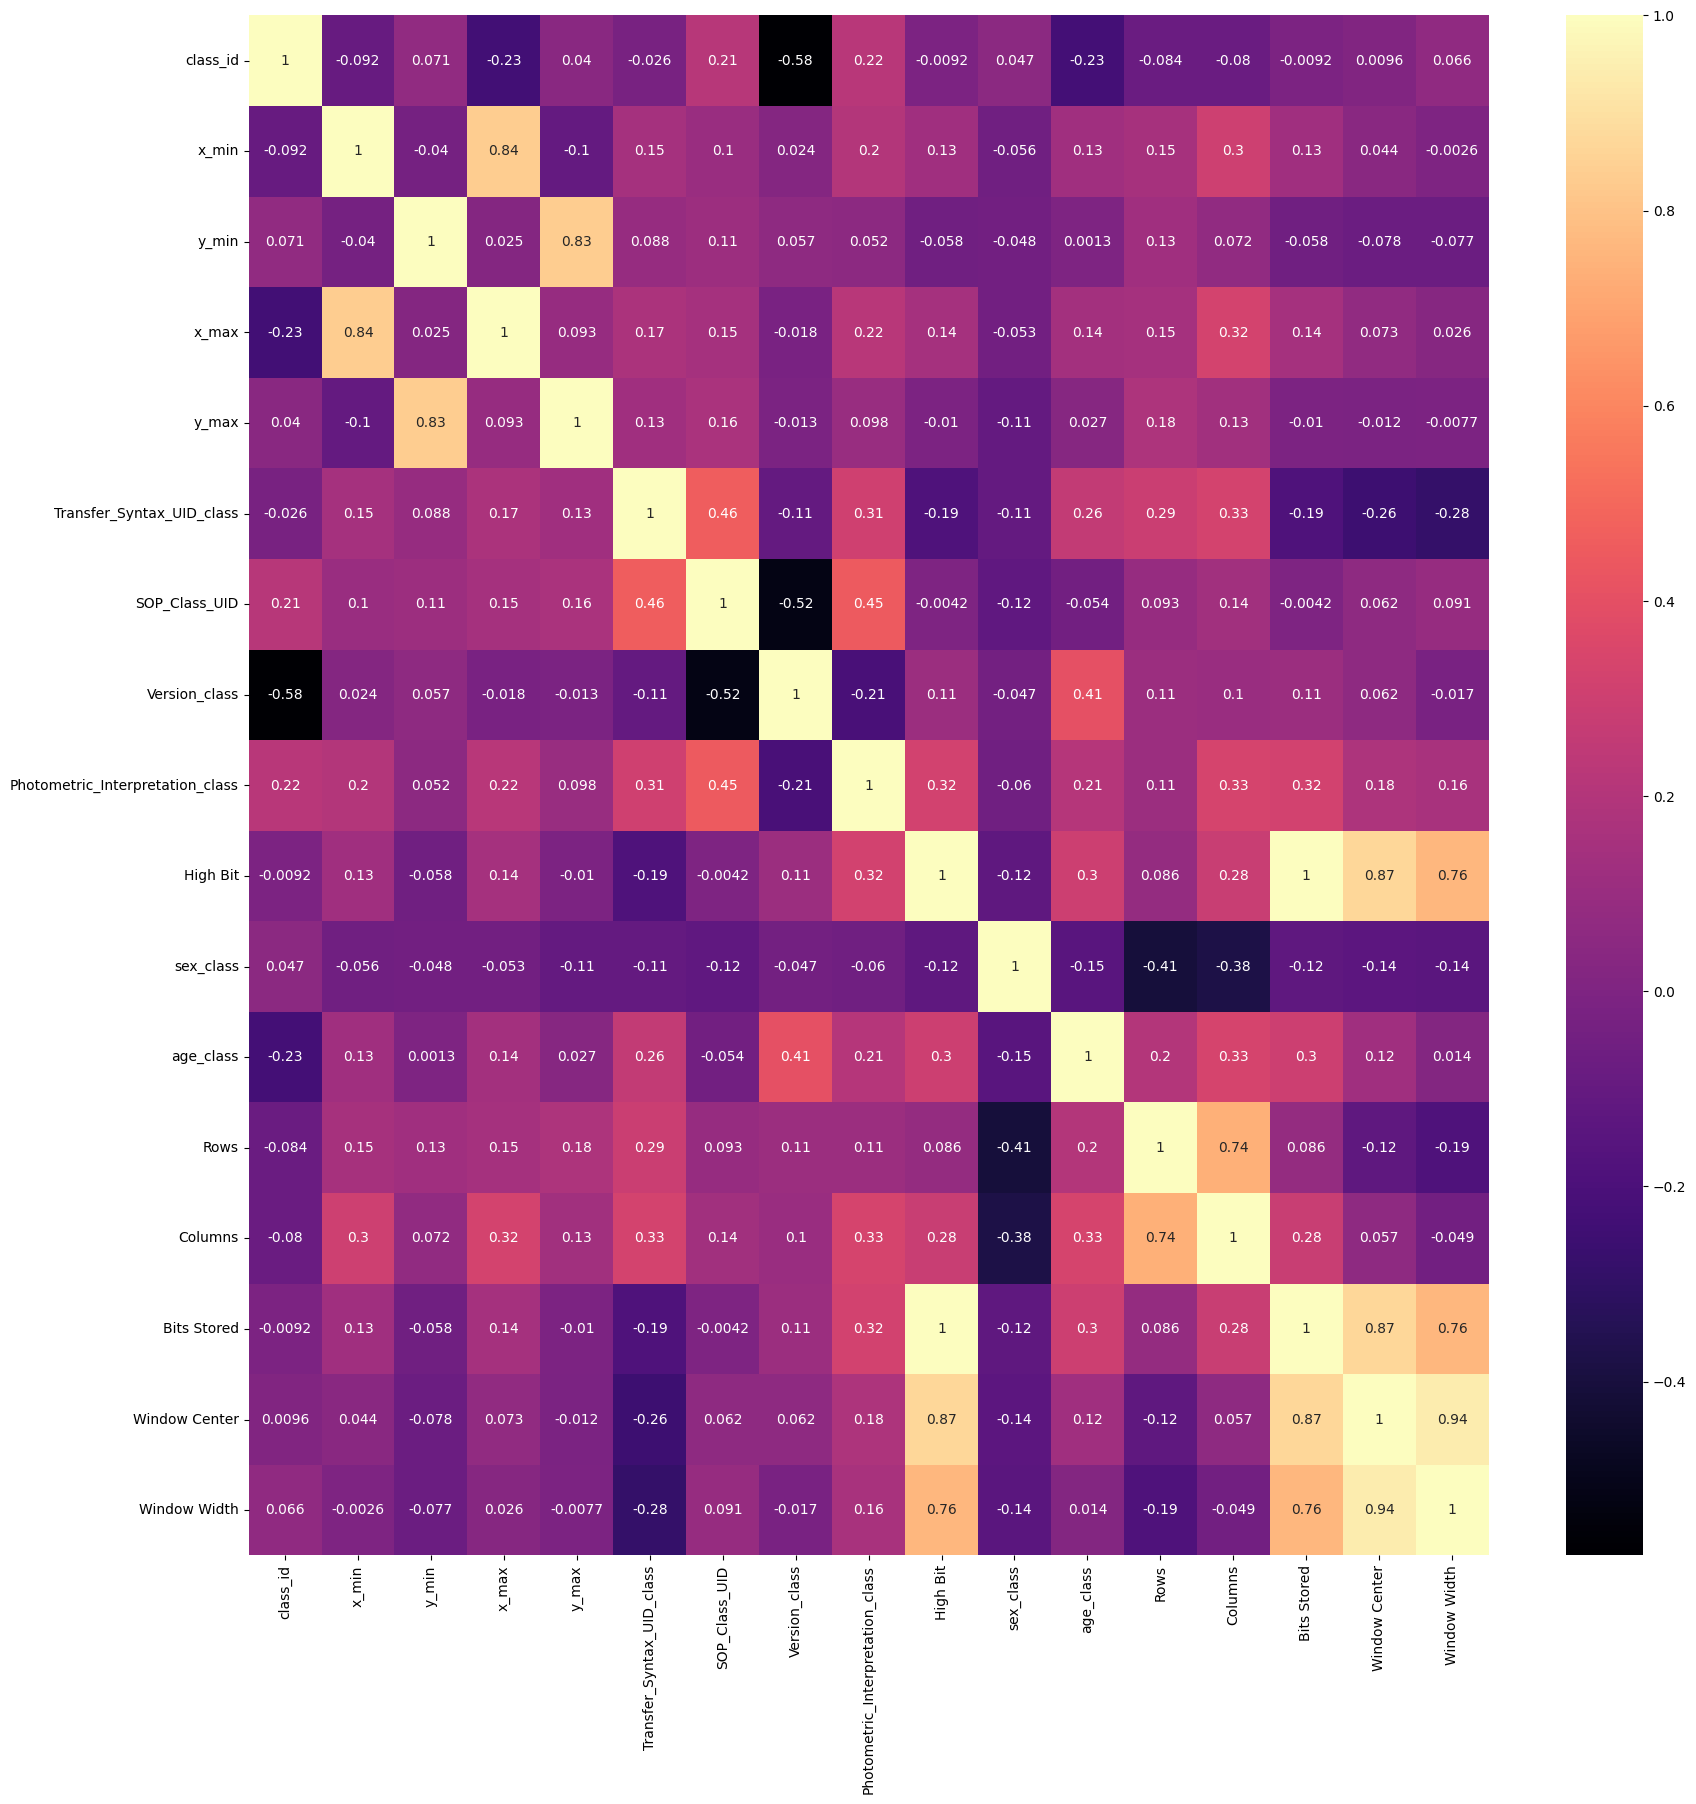

In [208]:
corr = df_merged[
    [
        "class_id",
        "rad_id",
        "x_min",
        "y_min",
        "x_max",
        "y_max",
        "Transfer_Syntax_UID_class",
        "SOP_Class_UID",
        "Version_class",
        "Photometric_Interpretation_class",
        "High Bit",
        "sex_class",
        "age_class",
        "Rows",
        "Columns",
        "Pixel Spacing",
        "Bits Stored",
        "Window Center",
        "Window Width",
    ]
].corr(numeric_only=True)

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap="magma")


In [209]:
train_df.shape

(67914, 8)

In [210]:
train_df["class_id"].unique()

array([14,  3,  0, 11,  5,  8, 13,  7,  1,  9,  6, 10,  2,  4, 12])

In [211]:
train_df["class_name"].unique()

array(['No finding', 'Cardiomegaly', 'Aortic enlargement',
       'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis',
       'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration',
       'Pleural effusion', 'Calcification', 'Consolidation',
       'Pneumothorax'], dtype=object)

In [212]:
train_df['image_id'].unique().shape

(15000,)

In [213]:
# Count number of classes for each image
image_class_count = train_df.groupby('image_id').size().reset_index(name='class_count')
image_class_count.head()

,image_id,class_count
0,000434271f63a053c4128a0ba6352c7f,3
1,00053190460d56c53cc3e57321387478,3
2,0005e8e3701dfb1dd93d53e2ff537b6e,5
3,0006e0a85696f6bb578e84fafa9a5607,3
4,0007d316f756b3fa0baea2ff514ce945,11


In [214]:

# Assuming df is your DataFrame loaded from the CSV
# Update this path to the directory where your DICOM files are stored
dicom_files_directory = '/Volumes/ALEXIS/ai_project_cranfield/train/'

def load_dicom(path):
    dicom = pydicom.dcmread(path)
    # Apply VOI LUT if available
    image = apply_voi_lut(dicom.pixel_array, dicom)
    # Normalize the image
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        image = np.amax(image) - image
    image = image - np.min(image)
    image = image / np.max(image)
    image = (image * 255).astype(np.uint8)
    return image

In [215]:
test_image = pydicom.dcmread(os.path.join(dicom_files_directory, train_df.iloc[40]['image_id'] + '.DICOM'))
print(test_image)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 8e063eadea9a6aeb684c893c8598be3e
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '061Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 3180
(0028, 0011) Columns                             US: 2836
(0028, 0030) Pixel Spacing

/Users/alexis/Cranfield/AI/assignment/chest-x-ray-abnormalities-detection/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '8e063eadea9a6aeb684c893c8598be3e'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


## Pixel Array Features Extraction

In [241]:
import logging
import h5py

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

def get_pixel_array_from_hdf5(hdf5_path, filename):
    """
    Retrieves the pixel array for a given filename from an HDF5 file.

    Parameters:
    - hdf5_path: Path to the HDF5 file.
    - filename: The original file name of the DICOM image.

    Returns:
    - A numpy array of the pixel data if found; None otherwise.
    """
    with h5py.File(hdf5_path, "r") as hdf5_file:
        # Attempt to access the dataset directly by filename.
        # Adjust this part if a more complex naming convention is used.
        unique_filename = None
        for key in hdf5_file.keys():
            if filename in key:
                unique_filename = key
                break
                
        if unique_filename is not None:
            pixel_array = hdf5_file[unique_filename][:]
            return pixel_array
        else:
            logging.error(f"File {filename} not found in HDF5.")
            return None

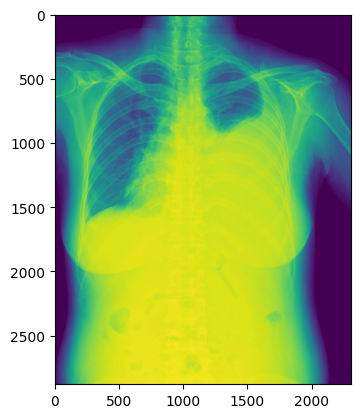

In [219]:
filename = "0a0ac65c40a9ac441651e4bfbde03c4e.dicom"  # This should be the base name of the file you're looking for.
pixel_array = get_pixel_array_from_hdf5("/Volumes/ALEXIS/ai_project_cranfield/dicom_images.hdf5", filename)
plt.imshow(pixel_array)

## Intensity Features Extraction

In [249]:
def extract_intensity_features(image):
    """
    Extracts intensity features from a given image.

    Parameters:
    - image: A 2D numpy array representing the image.

    Returns:
    - A dictionary containing the extracted features.
    """
    features = {}
    features["mean_intensity"] = np.mean(image)  # Mean intensity
    features["std_intensity"] = np.std(image)  # Standard deviation of intensity
    features["hist_intensity"], bin_edges = np.histogram(
        image.ravel(), bins=256, range=(0, 256), density=True
    )  # Intensity histogram
    return features

Mean Intensity: 155.5293157130112
Standard Deviation of Intensity: 87.50415111316013


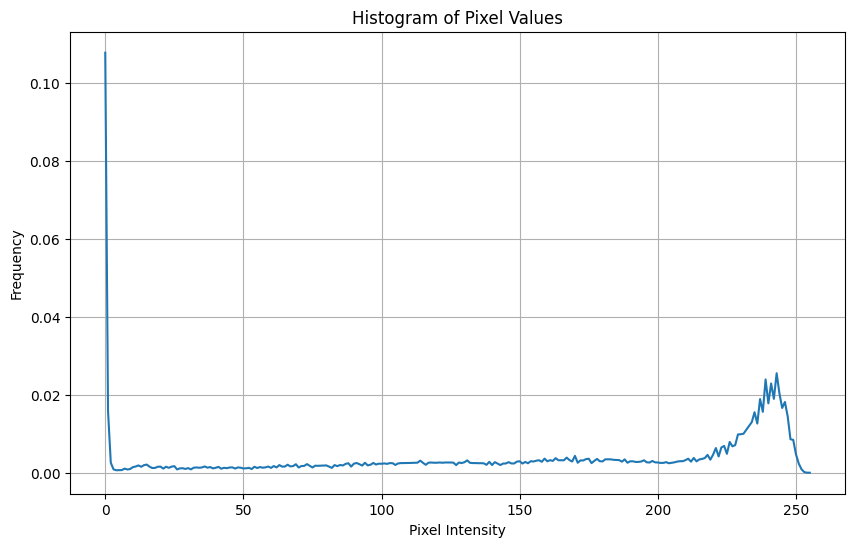

In [252]:
def plot_histogram(histogram, bin_edges):
    """
    Plot the histogram of pixel values.

    Parameters:
    - histogram: The values of the histogram.
    - bin_edges: The bin edges corresponding to the histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(
        bin_edges[0:-1], histogram
    )  # bin_edges is one element longer than histogram
    plt.title("Histogram of Pixel Values")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


intensity_features = extract_intensity_features(pixel_array) # Extract intensity features
print(f"Mean Intensity: {intensity_features['mean_intensity']}") # Print mean intensity
print(f"Standard Deviation of Intensity: {intensity_features['std_intensity']}") # Print standard deviation of intensity
plot_histogram(intensity_features["hist_intensity"], np.arange(257)) # Plot histogram

## Texture Features Extraction

### Gray-Level Co-occurrence Matrix (GLCM) Features

In [223]:
from skimage.feature import graycomatrix, graycoprops
import numpy as np


def calculate_glcm_features(image, distances, angles):
    """
    Calculate GLCM properties like contrast, correlation, energy, and homogeneity.

    Parameters:
    - image: 2D numpy array, preprocessed image.
    - distances: List of pixel distances for GLCM calculation.
    - angles: List of angles (in radians) for GLCM calculation.

    Returns:
    - Dictionary of GLCM features.
    """
    glcm = graycomatrix(
        image,
        distances=distances,
        angles=angles,
        levels=256,
        symmetric=True,
        normed=True,
    )
    features = {
        "contrast": graycoprops(glcm, "contrast").mean(),
        "correlation": graycoprops(glcm, "correlation").mean(),
        "energy": graycoprops(glcm, "energy").mean(),
        "homogeneity": graycoprops(glcm, "homogeneity").mean(),
    }
    return features

In [224]:
from skimage.feature import local_binary_pattern

def calculate_lbp_features(image, P, R, method='uniform'):
    """
    Calculate LBP features for capturing local texture patterns.
    
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - P: Number of circularly symmetric neighbour set points.
    - R: Radius of circle.
    - method: Method to determine the pattern.
    
    Returns:
    - LBP image.
    """
    lbp_image = local_binary_pattern(image, P, R, method)
    return lbp_image


In [225]:
from skimage.filters import gabor

def calculate_gabor_features(image, frequency, theta):
    """
    Apply Gabor filters to extract texture features.
    
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - frequency: Spatial frequency of the sinusoidal factor.
    - theta: Orientation of the normal to the parallel stripes of a Gabor function.
    
    Returns:
    - Gabor filtered image.
    """
    gabor_response_real, gabor_response_imag = gabor(image, frequency=frequency, theta=theta)
    return gabor_response_real, gabor_response_imag


In [226]:
glcm_features = calculate_glcm_features(pixel_array, distances=[1], angles=[0])
lbp_image = calculate_lbp_features(pixel_array, P=8, R=1)
gabor_response_real, gabor_response_imag = calculate_gabor_features(pixel_array, frequency=0.6, theta=0)

print("GLCM Features:", glcm_features)
print("LBP Image:", lbp_image)
print("Gabor Response (Real):", gabor_response_real)

GLCM Features: {'contrast': 12.400590413470354, 'correlation': 0.9991897232819489, 'energy': 0.10773901730783368, 'homogeneity': 0.3792180458373555}
LBP Image: [[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [3. 5. 9. ... 0. 8. 5.]
 [3. 6. 1. ... 8. 0. 5.]
 [3. 5. 3. ... 5. 5. 3.]]
Gabor Response (Real): [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [227]:
from skimage.filters import sobel

def apply_sobel_operator(image):
    """
    Apply the Sobel operator to highlight edges in the image.
    
    Parameters:
    - image: 2D numpy array, preprocessed image.
    
    Returns:
    - Sobel filtered image.
    """
    sobel_edges = sobel(image)
    return sobel_edges


In [228]:
from skimage.feature import canny

def apply_canny_edge_detector(image, sigma=1):
    """
    Use the Canny edge detector for identifying edges with more accuracy.
    
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - sigma: Standard deviation of the Gaussian filter used in Canny edge detector.
    
    Returns:
    - Canny edge detected image.
    """
    canny_edges = canny(image, sigma=sigma)
    return canny_edges


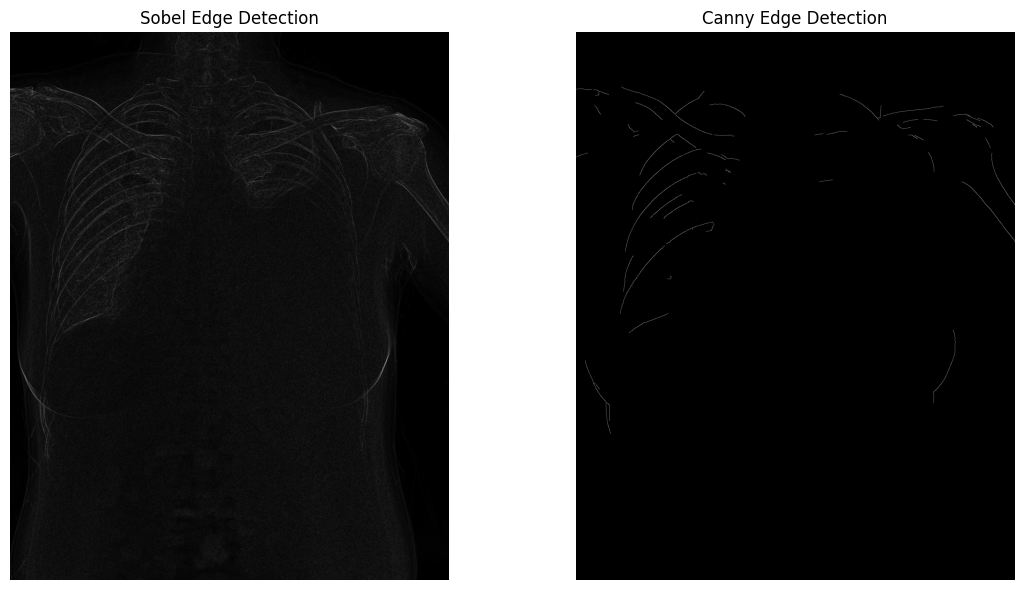

In [229]:
sobel_edges = apply_sobel_operator(pixel_array)
canny_edges = apply_canny_edge_detector(pixel_array, sigma=2)

# Display the results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(sobel_edges, cmap=plt.cm.gray)
ax[0].set_title('Sobel Edge Detection')

ax[1].imshow(canny_edges, cmap=plt.cm.gray)
ax[1].set_title('Canny Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [230]:
from skimage.feature import hog
from skimage import exposure

def calculate_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False):
    """
    Calculate HOG features to outline the presence of specific shapes or orientations.
    
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - visualize: If True, return an image of the HOG.
    
    Returns:
    - HOG features, and optionally the HOG image.
    """
    fd, hog_image = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=visualize, feature_vector=True)
    if visualize:
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        return fd, hog_image_rescaled
    else:
        return fd


In [231]:
from skimage.feature import canny
import numpy as np

def calculate_edge_count(image, sigma=1):
    """
    Count the number of edges detected by the Canny edge detection as a proxy for shape complexity.
    
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - sigma: Standard deviation of the Gaussian filter used in Canny edge detector.
    
    Returns:
    - The number of edge pixels.
    """
    edges = canny(image, sigma=sigma)
    edge_count = np.sum(edges)
    return edge_count


HOG Features: [0.         0.         0.         ... 0.21315228 0.         0.        ]
Edge Count: 10123


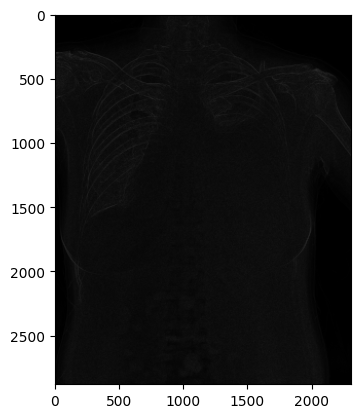

In [232]:
# Calculate HOG features
hog_features, hog_image = calculate_hog_features(pixel_array, visualize=True)
print("HOG Features:", hog_features)
plt.imshow(hog_image, cmap=plt.cm.gray)

# Calculate edge count
edge_count = calculate_edge_count(pixel_array, sigma=2)
print("Edge Count:", edge_count)

In [233]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy import ndimage

def calculate_statistical_features(image):
    """
    Calculate statistical features: skewness, kurtosis, and entropy.
    
    Parameters:
    - image: 2D numpy array, preprocessed image.
    
    Returns:
    - A dictionary containing the calculated features.
    """
    # Flatten the image to 1D for statistical analysis
    flattened_image = image.flatten()
    
    # Calculate skewness
    image_skewness = skew(flattened_image)
    
    # Calculate kurtosis
    image_kurtosis = kurtosis(flattened_image)
    
    # Calculate entropy
    histogram, _ = np.histogram(flattened_image, bins=256, range=(0, 255))
    histogram_normalized = histogram / histogram.sum()
    entropy = -np.sum(histogram_normalized * np.log2(histogram_normalized + np.finfo(float).eps))  # Add epsilon to avoid log(0)
    
    return {
        'skewness': image_skewness,
        'kurtosis': image_kurtosis,
        'entropy': entropy
    }


In [234]:
# Assuming `image` is your preprocessed image
# Example usage:

statistical_features = calculate_statistical_features(pixel_array)

print(f"Skewness: {statistical_features['skewness']}")
print(f"Kurtosis: {statistical_features['kurtosis']}")
print(f"Entropy: {statistical_features['entropy']}")

Skewness: -0.6349764872123987
Kurtosis: -1.0466161810474348
Entropy: 7.098414976311307


In [235]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, P=8, R=1, method='uniform', visualize=False):
    """
    Extract Local Binary Pattern (LBP) features.
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - P: Number of circularly symmetric neighbor set points.
    - R: Radius of circle.
    - method: Method for computing LBP.
    Returns:
    - LBP image.
    """
    lbp_image = local_binary_pattern(image, P, R, method)
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize

    
    if visualize:
        plt.figure(figsize=(8, 4))
        plt.bar(np.arange(0, P + 2), lbp_hist, width=0.8, align="center")
        plt.title('LBP Histogram')
        plt.xlabel('LBP Value')
        plt.ylabel('Frequency')
        plt.show()

    return lbp_hist

In [236]:
import mahotas.features

def extract_haralick_features(image, visualize=False):
    """
    Extract Haralick texture features using mahotas.
    Parameters:
    - image: 2D numpy array, preprocessed image.
    Returns:
    - Haralick features.
    """
    haralick_features = mahotas.features.haralick(image).mean(axis=0)

    # Visualize the Haralick features
    if visualize:
        plt.figure(figsize=(10, 5))
        plt.bar(np.arange(0, 13), haralick_features)
        plt.title('Haralick Texture Features')
        plt.xlabel('Feature')
        plt.ylabel('Value')
        plt.show()

    return haralick_features


In [237]:
import pywt

def extract_wavelet_features(image, mode='haar', level=1, visualize=False):
    """
    Extract Wavelet Transform features.
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - mode: Type of wavelet to use.
    - level: Decomposition level.
    Returns:
    - Concatenated wavelet coefficients.
    """
    coeffs = pywt.wavedec2(image, wavelet=mode, level=level)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]
    features = np.concatenate([cA.ravel(), cH.ravel(), cV.ravel(), cD.ravel()])
    
    if visualize:
        plt.figure(figsize=(12, 3))
        plt.title('Wavelet Decomposition')
        fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)
        axs[0].imshow(cA, cmap='gray')
        axs[0].set_title('Approximation')
        axs[1].imshow(cH, cmap='gray')
        axs[1].set_title('Horizontal Detail')
        axs[2].imshow(cV, cmap='gray')
        axs[2].set_title('Vertical Detail')
        axs[3].imshow(cD, cmap='gray')
        axs[3].set_title('Diagonal Detail')

        for ax in axs:
            ax.axis('off')

        plt.tight_layout()
        plt.show()
    
    return features


In [238]:
import numpy as np

def extract_fourier_features(image, visualize=False):
    """
    Extract Fourier Transform features.
    Parameters:
    - image: 2D numpy array, preprocessed image.
    Returns:
    - Flattened array of Fourier coefficients.
    """
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20*np.log(np.abs(f_shift) + 1)  # Adding 1 to avoid log(0)

    if visualize:
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Fourier Transform')
        plt.show()

    return magnitude_spectrum.ravel()


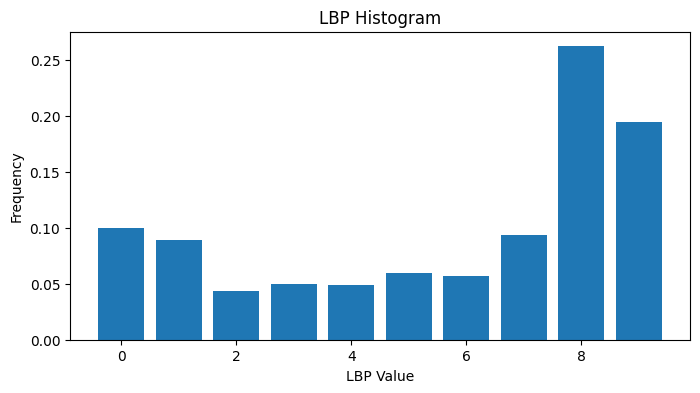

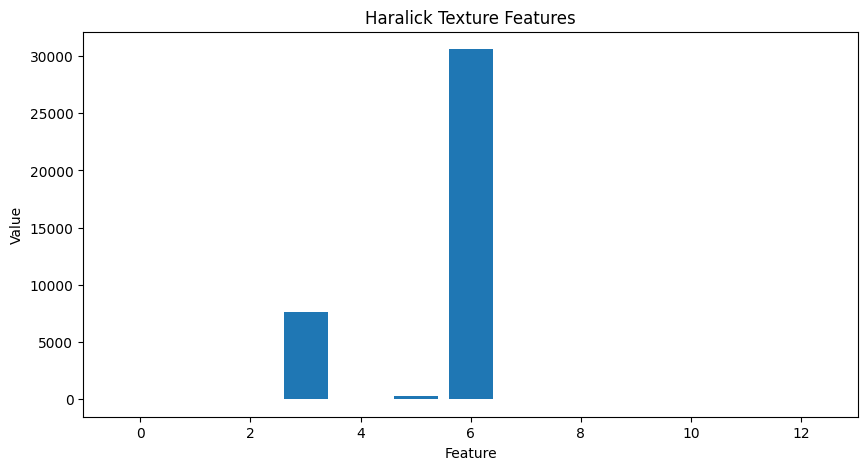

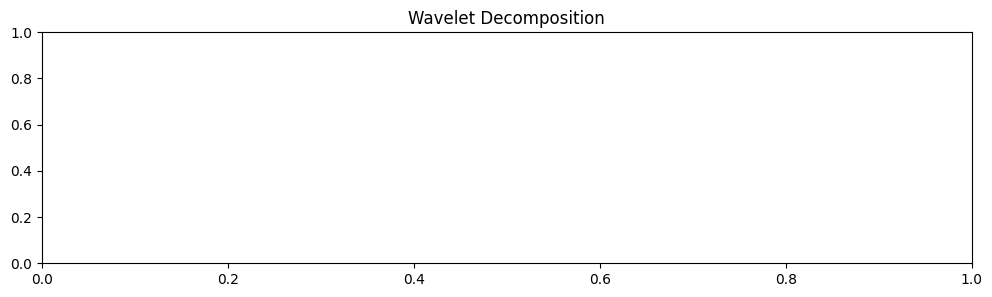

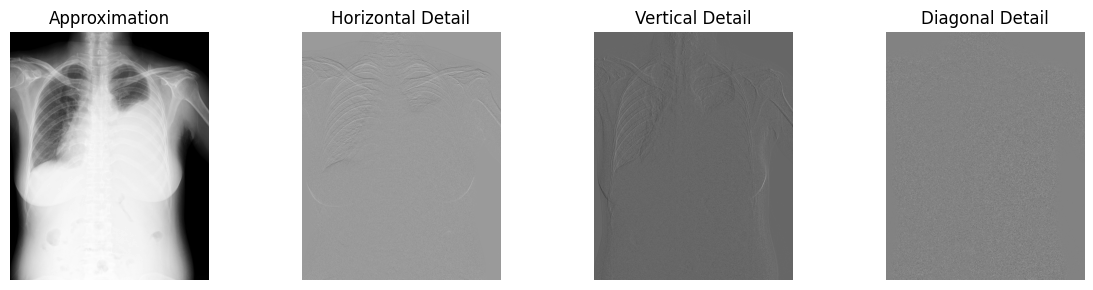

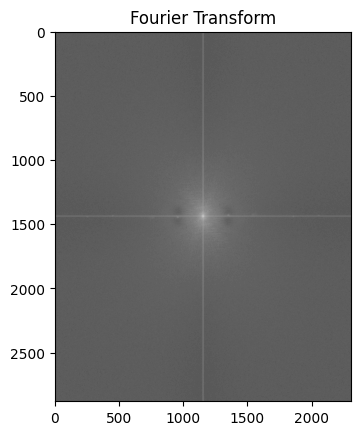

In [239]:
# Assuming `image` is your preprocessed image
lbp_features = extract_lbp_features(pixel_array, visualize=True)
haralick_features = extract_haralick_features(pixel_array, visualize=True)
wavelet_features = extract_wavelet_features(pixel_array, visualize=True)
fourier_features = extract_fourier_features(pixel_array, visualize=True)

Labelled Image


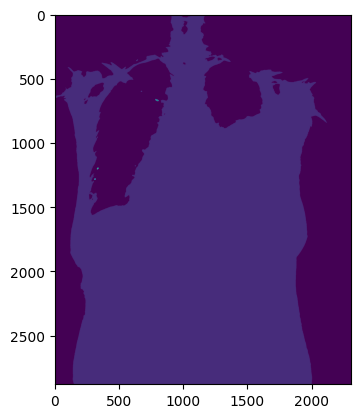

Haralick Features


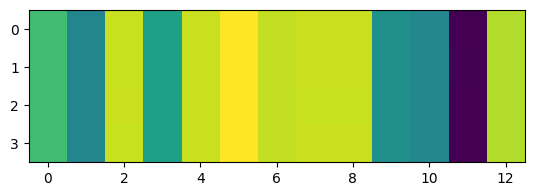

In [240]:
import mahotas
from pylab import imshow, show
 
# adding gaussian filter
nuclear = mahotas.gaussian_filter(pixel_array, 4)
 
# setting threshold
threshed = (nuclear > nuclear.mean())
 
# making is labeled image
labeled, n = mahotas.label(threshed)
 
# showing image
print("Labelled Image")
imshow(labeled)
show()
 
# getting haralick features
h_feature = mahotas.features.haralick(labeled)
 
# showing the feature
print("Haralick Features")
imshow(h_feature)
show()